# Method 1: Manually selecting Arima model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math
import time
from matplotlib import pyplot

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

import datetime
import operator
plt.style.use('fivethirtyeight')
%matplotlib inline

In [ ]:
# import the dataset for cases
# This is how we do it in colab

from google.colab import files
files.upload()

In [ ]:
# Store the dataset
confirmed_cases = pd.read_csv("time_series_covid19_confirmed_global.csv")
confirmed_cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,9/3/21,9/4/21,9/5/21,9/6/21,9/7/21,9/8/21,9/9/21,9/10/21,9/11/21,9/12/21,9/13/21,9/14/21,9/15/21,9/16/21,9/17/21,9/18/21,9/19/21,9/20/21,9/21/21,9/22/21,9/23/21,9/24/21,9/25/21,9/26/21,9/27/21,9/28/21,9/29/21,9/30/21,10/1/21,10/2/21,10/3/21,10/4/21,10/5/21,10/6/21,10/7/21,10/8/21,10/9/21,10/10/21,10/11/21,10/12/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,...,153375,153395,153423,153534,153626,153736,153840,153962,153982,153990,154094,154180,154283,154361,154487,154487,154487,154585,154712,154757,154800,154960,154960,154960,155072,155093,155128,155174,155191,155191,155191,155287,155309,155380,155429,155448,155466,155508,155540,155599
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,149117,150101,150997,151499,152239,153318,154316,155293,156162,157026,157436,158431,159423,160365,161324,162173,162953,163404,164276,165096,165864,166690,167354,167893,168188,168782,169462,170131,170778,171327,171794,171794,172618,173190,173723,174168,174643,174968,175163,175664
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,197308,197659,198004,198313,198645,198962,199275,199560,199822,200068,200301,200528,200770,200989,201224,201425,201600,201766,201948,202122,202283,202449,202574,202722,202877,203045,203198,203359,203517,203657,203789,203915,204046,204171,204276,204388,204490,204597,204695,204790
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15055,15055,15055,15069,15070,15070,15078,15083,15083,15083,15096,15099,15108,15113,15124,15124,15124,15140,15140,15153,15156,15167,15167,15167,15189,15192,15209,15222,15222,15222,15222,15267,15271,15284,15288,15291,15291,15291,15307,15307
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,48261,48475,48656,48790,49114,49349,49628,49943,50348,50446,50738,51047,51407,51827,52208,52307,52307,52644,52968,53387,53840,54280,54795,55121,55583,56040,56583,56583,58076,58603,58943,58943,59895,60448,60803,61023,61245,61378,61580,61794


In [ ]:
# Extract the dates columns 
cols = confirmed_cases.keys()
confirmed_case = confirmed_cases.loc[:,cols[4]:cols[-1]]

# Get a dataset with the dates and the total covid cases for that day
# ts = timeseries
confirmed_ts = confirmed_case.sum(axis=0)
confirmed_df = pd.DataFrame(confirmed_ts)


In [ ]:
#Convert dates in dataframe to datetime values
confirmed_df.columns = ["Cases"]
confirmed_df.index.names = ["Dates"]
confirmed_df.reset_index(inplace=True)
confirmed_df.Dates = pd.to_datetime(confirmed_df.Dates)
confirmed_df['Dates'].dt.strftime('%m/%d/%Y')


0      01/22/2020
1      01/23/2020
2      01/24/2020
3      01/25/2020
4      01/26/2020
          ...    
625    10/08/2021
626    10/09/2021
627    10/10/2021
628    10/11/2021
629    10/12/2021
Name: Dates, Length: 630, dtype: object

In [ ]:
confirmed_df

,Dates,Cases
0,2020-01-22,557
1,2020-01-23,655
2,2020-01-24,941
3,2020-01-25,1434
4,2020-01-26,2118
...,...,...
625,2021-10-08,237249330
626,2021-10-09,237578163
627,2021-10-10,237878832
628,2021-10-11,238272207


In [ ]:
# Reset Dates as index
confirmed_df2 = confirmed_df.set_index('Dates')

In [ ]:
confirmed_df2

,Cases
Dates,
2020-01-22,557
2020-01-23,655
2020-01-24,941
2020-01-25,1434
2020-01-26,2118
...,...
2021-10-08,237249330
2021-10-09,237578163
2021-10-10,237878832


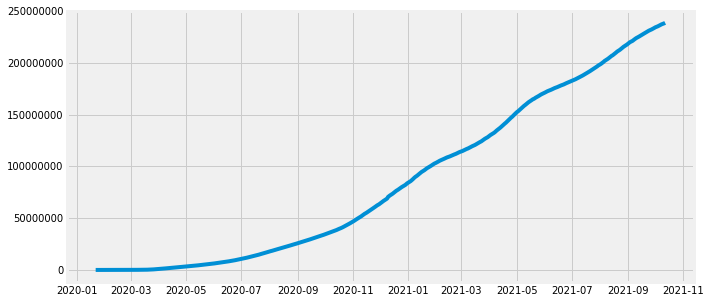

In [ ]:
# plot the dataframe
plt.figure(figsize=(10,5))
plt.ticklabel_format(style='plain')
plt.plot(confirmed_df2)
plt.show()

In [ ]:
confirmed_df2.index

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31',
               ...
               '2021-10-03', '2021-10-04', '2021-10-05', '2021-10-06',
               '2021-10-07', '2021-10-08', '2021-10-09', '2021-10-10',
               '2021-10-11', '2021-10-12'],
              dtype='datetime64[ns]', name='Dates', length=630, freq=None)

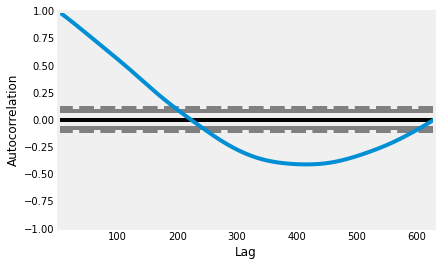

In [ ]:
# Autocorrelation plot for the cases over time
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(confirmed_df2)
plt.show()

In [ ]:
import pandas.util.testing as tm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  """Entry point for launching an IPython kernel.


In [ ]:
# Let us see if our series is stationary or not
# We see that the p-value is greater than 0.05, so it is not stationary
# Stationary means it has no trend and seasonality. From our graph, can clearly see an upward trend
# Also, there is a statistical term for this: univariate which means that there is only one variable we are looking at over time; in our case, the number of covid cases
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(confirmed_df2.Cases.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.746959
p-value: 0.990730


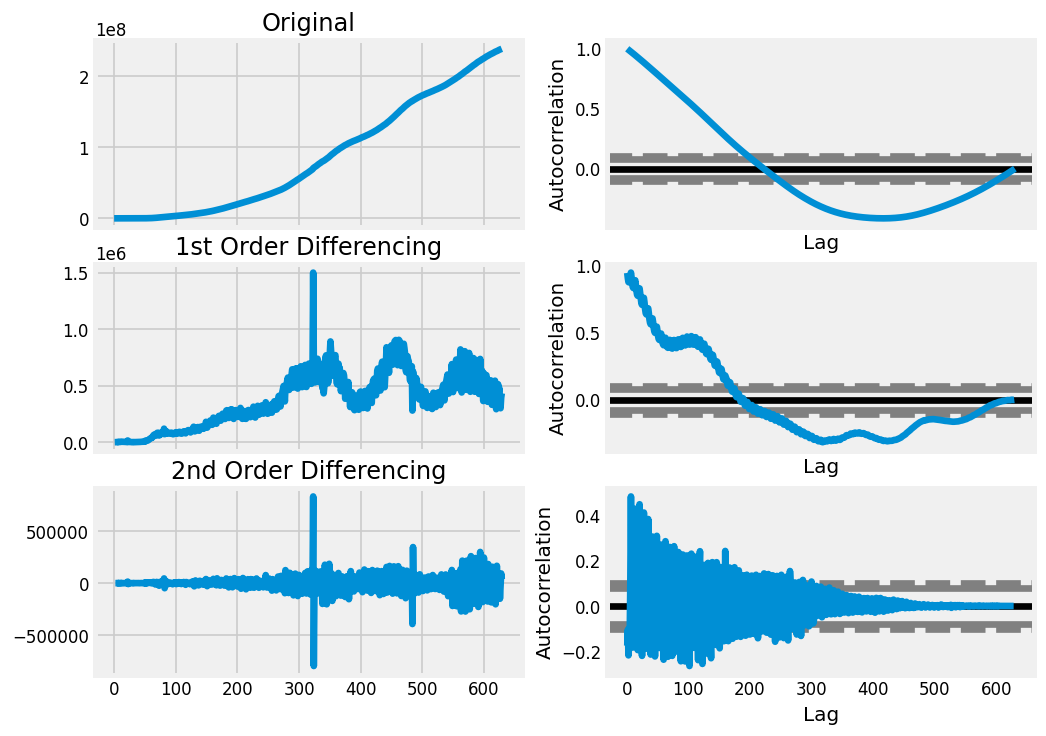

In [ ]:
# We will go ahead and difference to make it stationary
# plot the original and three differenced ones with autocorrelation
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(confirmed_df.Cases); axes[0, 0].set_title('Original')
autocorrelation_plot(confirmed_df.Cases, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(confirmed_df.Cases.diff()); axes[1, 0].set_title('1st Order Differencing')
autocorrelation_plot(confirmed_df.Cases.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(confirmed_df.Cases.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
autocorrelation_plot(confirmed_df.Cases.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

# We can see the second differencing pushes the values into the negative area, so we will stick with diference 1

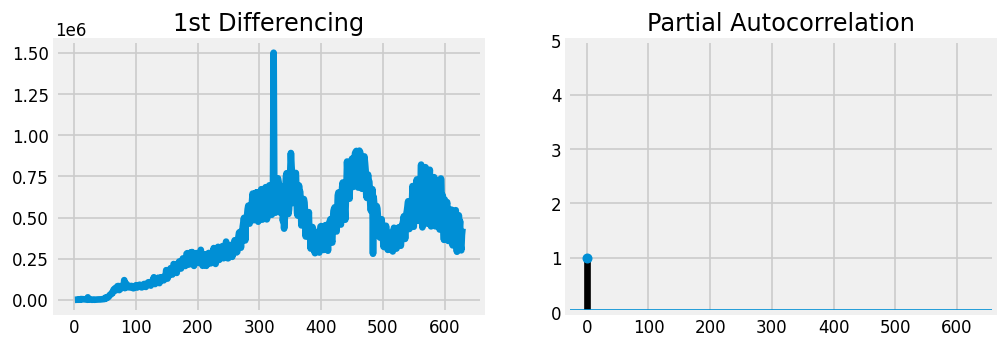

In [ ]:
# PACF plot of 1st differenced series to determine the AR term (p). 
# We see that it is 1
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(confirmed_df.Cases.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(confirmed_df.Cases.diff(), ax=axes[1])

plt.show()

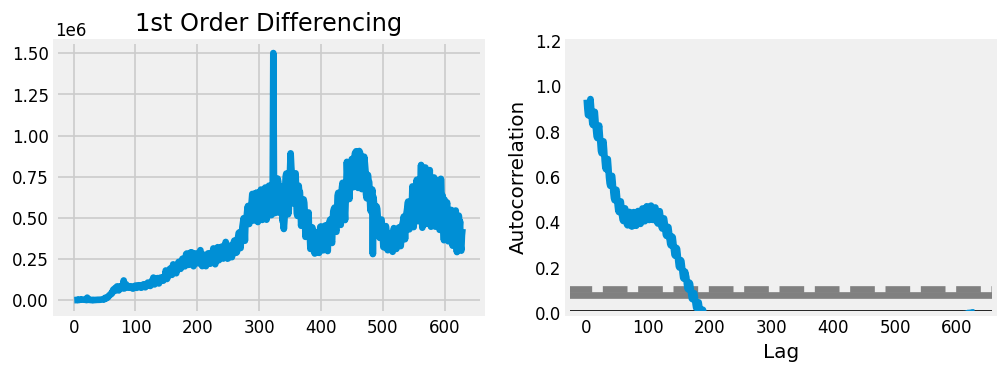

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True)
# axes[0].plot(confirmed_df.Cases.diff()); axes[0].set_title('1st Differencing')
# axes[1].set(ylim=(0,1.2))
# plot_acf(confirmed_df.Cases.diff().dropna(), ax=axes[1])

axes[0].plot(confirmed_df.Cases.diff()); axes[0].set_title('1st Order Differencing')
axes[1].set(ylim=(0,1.2))
autocorrelation_plot(confirmed_df.Cases.diff().dropna(), ax=axes[1])

plt.show()

# Build the model

In [ ]:
# Order of differencing, AR Term (p), MA term (q)
# 1,1,2 ARIMA Model
# We see the p-values for the AR, MA1, and MA2 are significant. We then decided to leave out the MA2 term. P-value was still less than 0.05, which is good.
# The AIC did not reduce significantly from dropping the MA2 term
model_original = ARIMA(confirmed_df2.Cases, order=(1,1,1)).fit(disp=0)
print(model_original.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Cases   No. Observations:                  629
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7988.303
Method:                       css-mle   S.D. of innovations          79118.172
Date:                Tue, 23 Nov 2021   AIC                          15984.606
Time:                        17:21:09   BIC                          16002.382
Sample:                    01-23-2020   HQIC                         15991.511
                         - 10-12-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.795e+05   1.69e+05      2.241      0.025    4.76e+04    7.11e+05
ar.L1.D.Cases     0.9957      0.004    270.722      0.000       0.988       1.003
ma.L1.D.Cases    -0.7138      0.033    -

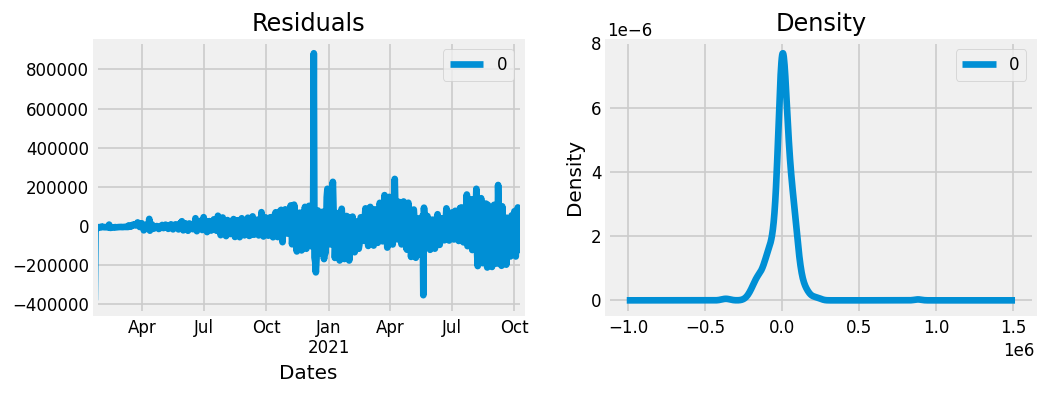

In [ ]:
# Plot residual errors to ensure there are no patterns or trends
# We see that the residual error has a zero mean and constant variance
residuals = pd.DataFrame(model_original.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf

In [ ]:
confirmed_df2.columns

Index(['Cases'], dtype='object')

In [ ]:
# Create Training and Test
train, test = train_test_split(confirmed_df2, test_size = 0.25, shuffle=False)
x_train, x_test, y_train, y_test = train_test_split(confirmed_df2.index, confirmed_df2.Cases, test_size = 0.25, shuffle=False)


In [ ]:
# Build Model on the training dataset
# model = ARIMA(train, order=(3,2,1)) = the predicted results with this were way off
model_train = ARIMA(train, order=(1, 1, 1)) .fit(disp=-1)  
print(model_train.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Cases   No. Observations:                  471
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5941.336
Method:                       css-mle   S.D. of innovations          72585.917
Date:                Tue, 23 Nov 2021   AIC                          11890.673
Time:                        17:21:20   BIC                          11907.292
Sample:                    01-23-2020   HQIC                         11897.210
                         - 05-07-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.333e+05   1.04e+05      3.196      0.001    1.29e+05    5.38e+05
ar.L1.D.Cases     0.9760      0.011     85.836      0.000       0.954       0.998
ma.L1.D.Cases    -0.1914      0.071     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [ ]:
# Forecast
# fc, val, conf = fitted.forecast(len(y_test), alpha=0.05)  # 95% conf. Plot the y_test results = forecast
pred_train, val, conf = model_train.forecast(len(x_test), alpha = 0.05)

In [ ]:
# Make as pandas series
pred_train_series = pd.Series(pred_train, index= x_test)  # This is the case numbers (fc = forecast)
lower_series = pd.Series(conf[:, 0], index=y_test.index)
upper_series = pd.Series(conf[:, 1], index=y_test.index)

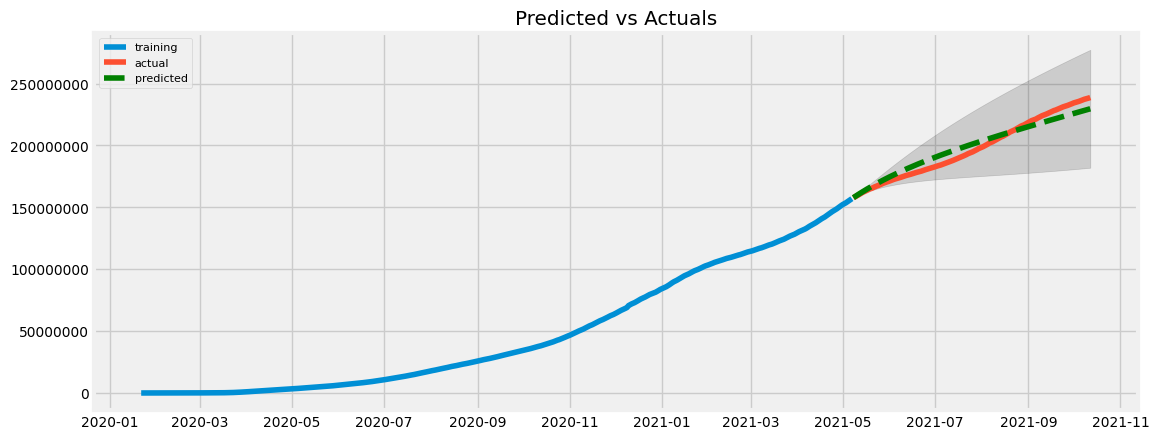

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.ticklabel_format(style='plain')
plt.plot(y_train, label='training')
plt.plot(y_test, label='actual')
plt.plot(pred_train_series, label='predicted', linestyle='dashed', color = "green")
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Predicted vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# rmse = np.mean((fc - y_test.Cases)**2)**.5
# rmse
mse = mean_squared_error(pred_train, y_test)   # Predicted, actual
rmse = math.sqrt(mse)
mape = np.mean(np.abs(pred_train - y_test)/np.abs(y_test))
print("RMSE:", rmse)
print("MAPE", mape)

# We can see that we have a mean absolute percentage error (MAPE) of 2.5 % which suggests that the model is 97.5% accurate in predicting the test data for 158 rows
# The higher RMSE is due to the range of our values. Our main aim was to compare the RMSE with the different models to see which one yields the lowest value
# Compared to the polynomial regression, this is much lower 

RMSE: 5664688.492103486
MAPE 0.02499563675090618


# Make prediction for today (11/11/2021)

In [ ]:
from datetime import date
#date.today()

# Since our dataset ended in October, we wanted to see how close the real values are with the model
# So, we decided to look at the number of cases till November 11th, 2021 (that was the time we were done with the project)
# We checked the number of global cases that day and saw the value of ~251 million
# Once we run our model and compute the maximum value for the 27 days
# we see the value of 250 million; 250,649,600 to be precise. 
# This is pretty close and accurate; enough to make us satisfied with our model

pred_today = pd.date_range(start="2021-10-13",end="2021-11-12")
days_till_today = len(pred_today)
pred_today, val, conf = model_original.forecast(days_till_today, alpha=0.05)
pred_today[-1]

# We can see that the cases are morethan 250 million and the true cases today are 251 million, so our model did a pretty good job

251046531.27982783

# Making predictions till September 2022

In [ ]:
# We tried our best to optimize the model. Since, this is the best model we got so far, we decided to proceed with predictions
# Get the length of the time period in days

pred_index = pd.date_range(start="2021-10-13",end="2022-10-13")
future_days = len(pred_index)
pred, val, conf = model_original.forecast(future_days, alpha=0.05)
pred_series = pd.Series(pred, index=pred_index)

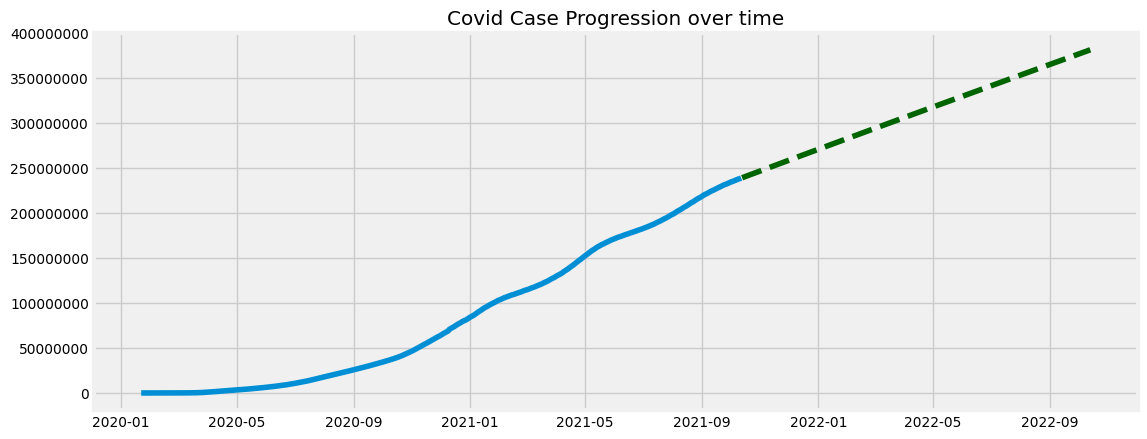

In [ ]:
# Plot

plt.figure(figsize=(12,5), dpi=100)
plt.ticklabel_format(style='plain')
plt.plot(confirmed_df2.Cases)
plt.plot(pred_series, linestyle='dashed', color='darkgreen')

plt.title("Covid Case Progression over time")
plt.show()

# Predictions for deaths

In [ ]:
# import the dataset for deaths
# This is how we do it in colab

from google.colab import files
files.upload()

In [ ]:
# Store the dataset
death_cases = pd.read_csv("time_series_covid19_deaths_global.csv")

# Extract the dates columns 
cols = death_cases.keys()
deaths = death_cases.loc[:,cols[4]:cols[-1]]

# Get a dataset with the dates and the total covid cases for that day
# ts = timeseries
deaths_ts = deaths.sum(axis=0)
deaths_df = pd.DataFrame(deaths_ts)

In [ ]:
#Convert dates in dataframe to datetime values
deaths_df.columns = ["Deaths"]
deaths_df.index.names = ["Dates"]
deaths_df.reset_index(inplace=True)
deaths_df.Dates = pd.to_datetime(deaths_df.Dates)
deaths_df['Dates'].dt.strftime('%m/%d/%Y')


0      01/22/2020
1      01/23/2020
2      01/24/2020
3      01/25/2020
4      01/26/2020
          ...    
625    10/08/2021
626    10/09/2021
627    10/10/2021
628    10/11/2021
629    10/12/2021
Name: Dates, Length: 630, dtype: object

In [ ]:
deaths_df

,Dates,Deaths
0,2020-01-22,17
1,2020-01-23,18
2,2020-01-24,26
3,2020-01-25,42
4,2020-01-26,56
...,...,...
625,2021-10-08,4842432
626,2021-10-09,4847106
627,2021-10-10,4851586
628,2021-10-11,4857420


In [ ]:
# Reset Dates as index
deaths_df2 = deaths_df.set_index('Dates')

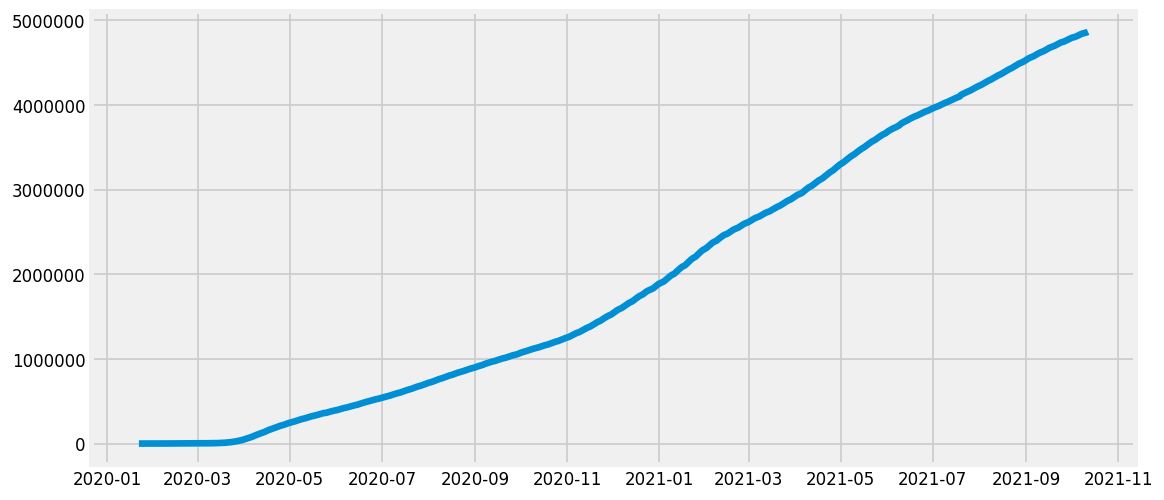

In [ ]:
# plot the dataframe
plt.figure(figsize=(10,5))
plt.ticklabel_format(style='plain')
plt.plot(deaths_df2)
plt.show()

In [ ]:
result = adfuller(deaths_df2.Deaths.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.458365
p-value: 0.983551


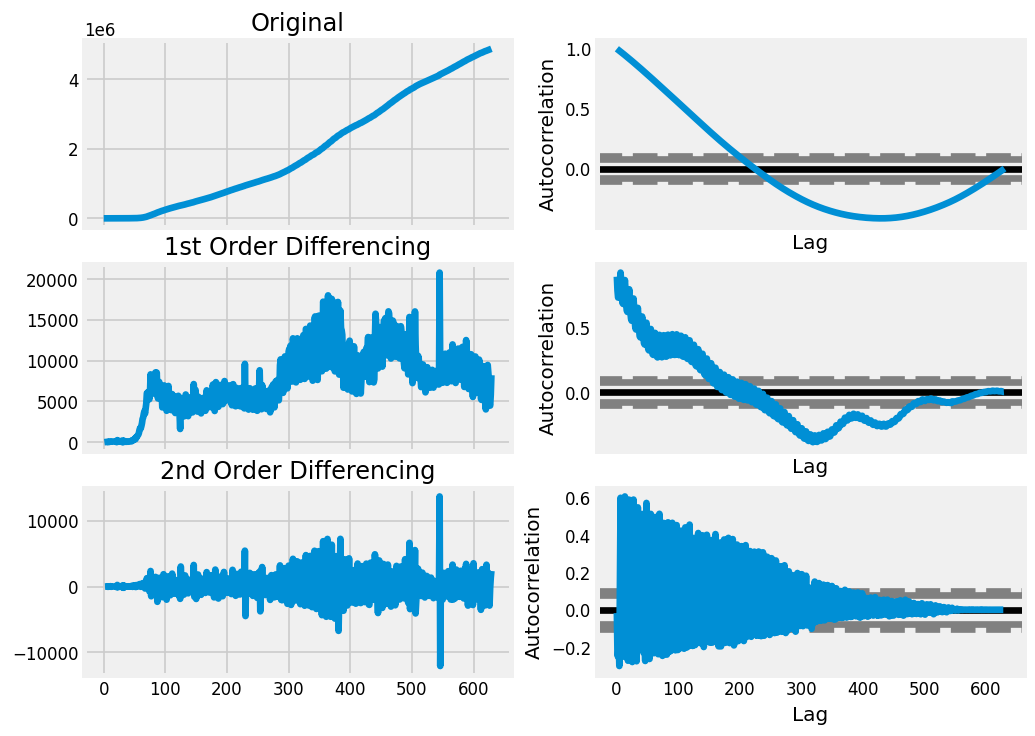

In [ ]:
# We will go ahead and difference to make it stationary
# plot the original and three differenced ones with autocorrelation
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(deaths_df.Deaths); axes[0, 0].set_title('Original')
autocorrelation_plot(deaths_df.Deaths, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(deaths_df.Deaths.diff()); axes[1, 0].set_title('1st Order Differencing')
autocorrelation_plot(deaths_df.Deaths.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(deaths_df.Deaths.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
autocorrelation_plot(deaths_df.Deaths.diff().diff().dropna(), ax=axes[2, 1])

plt.show()


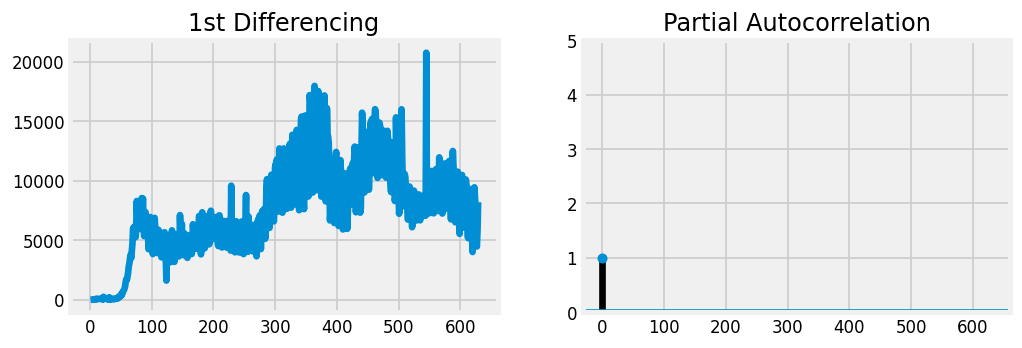

In [ ]:
# PACF plot of 1st differenced series to determine the AR term (p). 
# We see that it is 1
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(deaths_df.Deaths.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(deaths_df.Deaths.diff(), ax=axes[1])

plt.show()

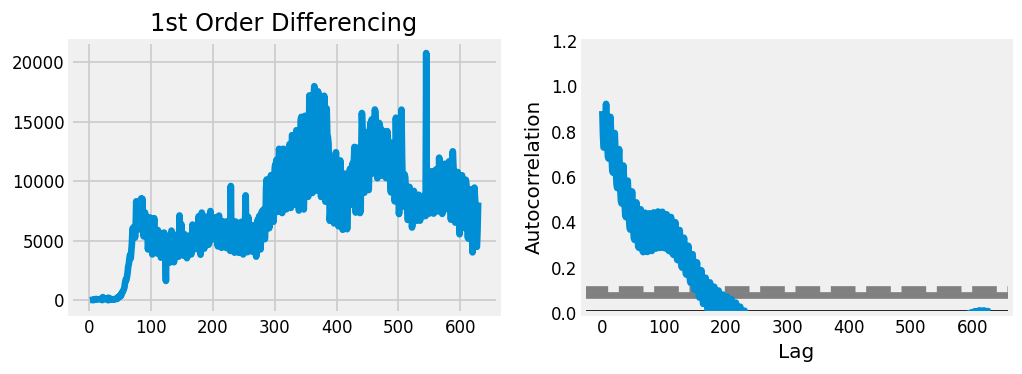

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True)
# axes[0].plot(confirmed_df.Cases.diff()); axes[0].set_title('1st Differencing')
# axes[1].set(ylim=(0,1.2))
# plot_acf(confirmed_df.Cases.diff().dropna(), ax=axes[1])

axes[0].plot(deaths_df.Deaths.diff()); axes[0].set_title('1st Order Differencing')
axes[1].set(ylim=(0,1.2))
autocorrelation_plot(deaths_df.Deaths.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
# Order of differencing, AR Term (p), MA term (q)
# 1,1,2 ARIMA Model
# We see the p-value for the MA term was greater than 0.05 with the model (1,1,1). So, we decided to use (1,1,0) which gave us significant p-values. Also, with Arima (1,1,2)
# on the trainign set, it gave up p-values greater than 0.05, that is why we decided not to use the MA term.
model_originalD = ARIMA(deaths_df2.Deaths, order=(1,1,0)).fit(disp=0)
print(model_originalD.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                  629
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -5614.141
Method:                       css-mle   S.D. of innovations           1817.637
Date:                Tue, 23 Nov 2021   AIC                          11234.282
Time:                        17:19:28   BIC                          11247.614
Sample:                    01-23-2020   HQIC                         11239.461
                         - 10-12-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           7601.5065    670.614     11.335      0.000    6287.127    8915.886
ar.L1.D.Deaths     0.8932      0.018     49.742      0.000       0.858       0.928
                                    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


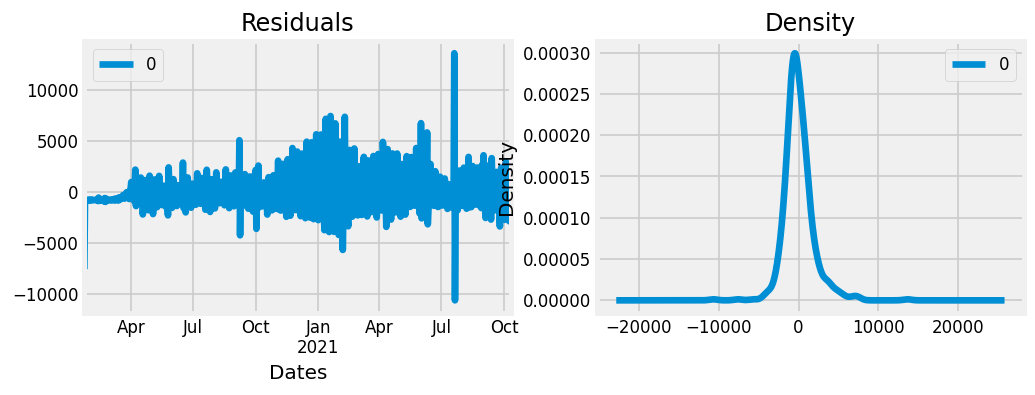

In [ ]:
# Plot residual errors to ensure there are no patterns or trends
# We see that the residual error has a zero mean and constant variance
residuals = pd.DataFrame(model_originalD.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
#mCreate Training and Test
trainD, testD = train_test_split(deaths_df2, test_size = 0.25, shuffle=False)
x_trainD, x_testD, y_trainD, y_testD = train_test_split(deaths_df2.index, deaths_df2.Deaths, test_size = 0.25, shuffle=False)

In [ ]:
# Build Model on the training dataset
# model = ARIMA(train, order=(1,1,2))
model_trainD = ARIMA(trainD, order=(1, 1, 0)) .fit(disp=-1)  
print(model_trainD.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                  471
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -4170.730
Method:                       css-mle   S.D. of innovations           1692.714
Date:                Tue, 23 Nov 2021   AIC                           8347.460
Time:                        17:19:29   BIC                           8359.925
Sample:                    01-23-2020   HQIC                          8352.364
                         - 05-07-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           7173.8673    986.434      7.273      0.000    5240.493    9107.242
ar.L1.D.Deaths     0.9229      0.018     51.327      0.000       0.888       0.958
                                    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [ ]:
# Forecast
# fc, val, conf = fitted.forecast(len(y_test), alpha=0.05)  # 95% conf. Plot the y_test results = forecast
pred_trainD, val, conf = model_trainD.forecast(len(x_testD), alpha = 0.05)

In [ ]:
# Make as pandas series
pred_train_seriesD = pd.Series(pred_trainD, index= x_testD)  
lower_seriesD = pd.Series(conf[:, 0], index=y_testD.index)
upper_seriesD = pd.Series(conf[:, 1], index=y_testD.index)

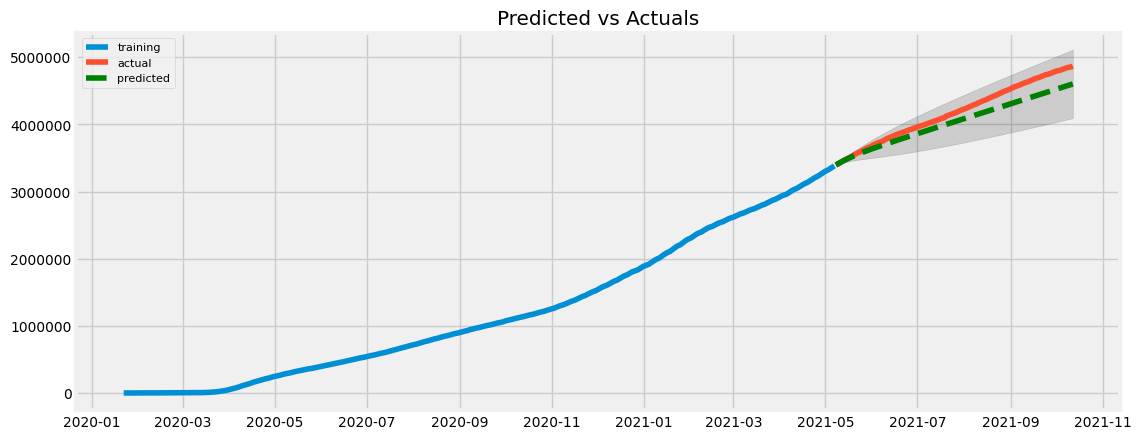

In [ ]:
# Plot
# We see the predicted is within the 95% confidence interval range whcih is good
plt.figure(figsize=(12,5), dpi=100)
plt.ticklabel_format(style='plain')
plt.plot(y_trainD, label='training')
plt.plot(y_testD, label='actual')
plt.plot(pred_train_seriesD, label='predicted', linestyle='dashed', color = "green")
plt.fill_between(lower_seriesD.index, lower_seriesD, upper_seriesD, 
                 color='k', alpha=.15)
plt.title('Predicted vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
mse = mean_squared_error(pred_trainD, y_testD)   # Predicted, actual
rmse = math.sqrt(mse)
mape = np.mean(np.abs(pred_trainD - y_testD)/np.abs(y_testD))
print("RMSE:", rmse)
print("MAPE", mape)

# As we can see, we got an even better result from the covid cases predictions and that is because the deaths are less in number. We had almost about 150 million cases 
# whereas the deaths are about 50 million. An RMSE of 1 million for this dataset is not that bad. We see the percentage error is 3.2% which is great to proceed with predictions

RMSE: 166976.87898177415
MAPE 0.032587516965931464


# Make predictions for today (11/12/2021)

In [ ]:
pred_todayD = pd.date_range(start="2021-10-13",end="2021-11-12")
days_till_todayD = len(pred_todayD)
pred_todayD, val, conf = model_originalD.forecast(days_till_todayD, alpha=0.05)
pred_todayD[-1]

# We see the deaths today are get to 5 million and our model also predicted the same number of deaths.

5106113.271508694

# Making predictions till 10/13/2021

In [ ]:
# We tried our best to optimize the model. Since, this is the best model we got so far, we decided to proceed with predictions
# Get the length of the time period in days

pred_indexD = pd.date_range(start="2021-10-13",end="2022-10-13")
future_daysD = len(pred_indexD)
predD, val, conf = model_originalD.forecast(future_daysD, alpha=0.05)
pred_seriesD = pd.Series(predD, index=pred_indexD)

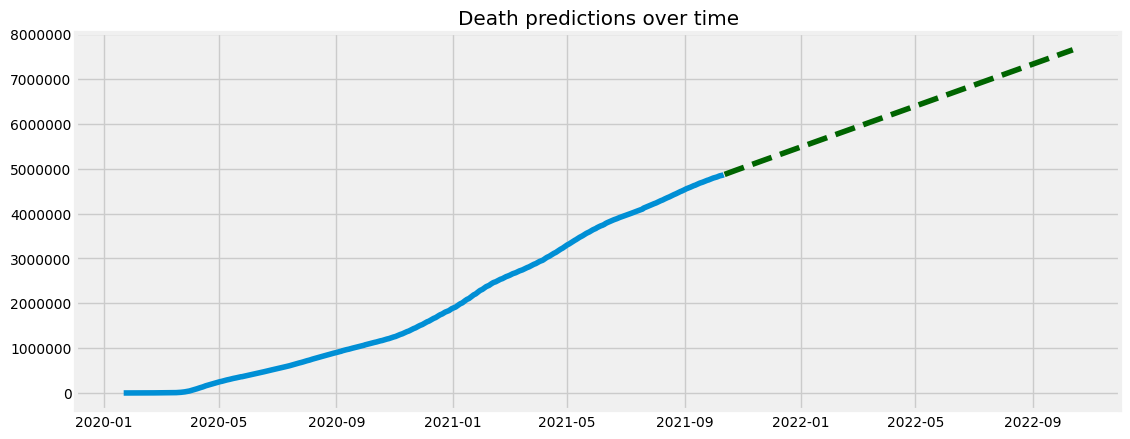

In [ ]:
# Plot

plt.figure(figsize=(12,5), dpi=100)
plt.ticklabel_format(style='plain')
plt.plot(deaths_df2.Deaths)
plt.plot(pred_seriesD, linestyle='dashed', color='darkgreen')

plt.title("Death predictions over time")
plt.show()

# Our predictions show that the deaths will rise to about 8 million next year in October